# NN-Session-3 MLX Solution: Advanced Neural Network Tuning

This notebook provides an Apple Silicon optimized solution for the NN-session-3 exercises using the MLX framework.
It demonstrates advanced techniques for tuning neural networks to achieve high accuracy.

## 1. Setup and Library Imports

In [15]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# MLX Imports
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

%matplotlib inline

np.random.seed(42)
mx.random.seed(42)

print(f"MLX version: {mx.__version__}")

MLX version: 0.30.1


## 2. Data Preparation

In [16]:
# SOLUTION: Load and preprocess 18-apps dataset
try:
    df = pd.read_csv("../sherlock/sherlock_18apps.csv", index_col=0)
except FileNotFoundError:
    df = pd.read_csv("sherlock/sherlock_18apps.csv", index_col=0)

# Data cleaning
df2 = df.copy()
df2 = df2.drop(['Unnamed: 0'], axis=1, errors='ignore')

# Drop columns with too many missing values (>50% missing)
missing_threshold = 0.5
missing_percent = df2.isna().sum() / len(df2)
cols_to_drop = missing_percent[missing_percent > missing_threshold].index.tolist()
print(f"Columns with >{missing_threshold*100}% missing values: {cols_to_drop}")
df2 = df2.drop(columns=cols_to_drop)

# Remove rows with remaining missing values
df2.dropna(inplace=True)

# Separate labels and features
labels = df2['ApplicationName']
df_features = df2.drop('ApplicationName', axis=1)

# Feature scaling - handle numeric and categorical features separately
numeric_features = df_features.select_dtypes(include=[np.number])
categorical_features = df_features.select_dtypes(exclude=[np.number])

print(f"Numeric features: {numeric_features.shape[1]} columns")
print(f"Categorical features: {categorical_features.shape[1]} columns")

# Scale only numeric features
scaler = preprocessing.StandardScaler()
scaler.fit(numeric_features)
numeric_features_n = pd.DataFrame(scaler.transform(numeric_features),
                                   columns=numeric_features.columns,
                                   index=numeric_features.index)

# Combine scaled numeric features with categorical features
if categorical_features.shape[1] > 0:
    df_features_n = pd.concat([numeric_features_n, categorical_features], axis=1)
else:
    df_features_n = numeric_features_n

# One-hot encoding
df_labels_onehot = pd.get_dummies(labels)
df_features_encoded = pd.get_dummies(df_features_n)

# Train-test split
train_F, test_F, train_L, test_L = train_test_split(
    df_features_encoded, df_labels_onehot, test_size=0.2, random_state=42
)

print(f"\nTraining set: {train_F.shape}")
print(f"Test set: {test_F.shape}")
print(f"Number of classes: {train_L.shape[1]}")

# Convert to MLX arrays
def to_mlx(x):
    return mx.array(x.values.astype(np.float32))

train_F_mx = to_mlx(train_F)
test_F_mx = to_mlx(test_F)
train_L_mx = to_mlx(train_L)
test_L_mx = to_mlx(test_L)

Columns with >50.0% missing values: ['cminflt']
Numeric features: 16 columns
Categorical features: 1 columns

Training set: (218461, 20)
Test set: (54616, 20)
Number of classes: 18


## 3. Hyperparameter Tuning Experiments with MLX

In [17]:
# SOLUTION: Define function to create MLX models with different architectures
def create_model(input_dim, output_dim, hidden_layers=[128, 64, 32], dropout_rate=0.2):
    layers = []
    
    # Input layer to first hidden
    prev_dim = input_dim
    
    for units in hidden_layers:
        layers.append(nn.Linear(prev_dim, units))
        layers.append(nn.BatchNorm(units))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))
        prev_dim = units
        
    # Output layer
    layers.append(nn.Linear(prev_dim, output_dim))
    
    return nn.Sequential(*layers)

print("Model creation function defined!")

Model creation function defined!


In [18]:
# Universal Training Function for Experiments
def train_experiment(model, optimizer, train_X, train_y, test_X, test_y, epochs=5, batch_size=32, name="Model", early_stopping=False, patience=10):
    # Note: Reduced default epochs to 5 for fast verification
    
    def loss_fn(model, X, y):
        return mx.mean(nn.losses.cross_entropy(model(X), y))

    def train_step(model, optimizer, X, y):
        loss, grads = nn.value_and_grad(model, loss_fn)(model, X, y)
        optimizer.update(model, grads)
        return loss

    num_samples = train_X.shape[0]
    num_batches = num_samples // batch_size
    
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
    
    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    print(f"Training {name}...")
    
    for epoch in range(epochs):
        perm = mx.random.permutation(num_samples)
        epoch_loss = 0.0
        
        model.train() 
        
        for i in range(num_batches):
            ids = perm[i * batch_size : (i + 1) * batch_size]
            X_batch = train_X[ids]
            y_batch = train_y[ids]
            
            batch_loss = train_step(model, optimizer, X_batch, y_batch)
            epoch_loss += batch_loss.item()
            if (i+1) % 100 == 0:
                 mx.eval(model.parameters(), optimizer.state)

        avg_train_loss = epoch_loss / num_batches
        
        model.eval()
        val_logits = model(test_X)
        val_loss = mx.mean(nn.losses.cross_entropy(val_logits, test_y)).item()
        
        train_acc = mx.mean(mx.argmax(model(train_X), axis=1) == mx.argmax(train_y, axis=1)).item()
        val_acc = mx.mean(mx.argmax(val_logits, axis=1) == mx.argmax(test_y, axis=1)).item()
        
        history['loss'].append(avg_train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)
        
        # Early Stopping Logic
        if early_stopping:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
                # Ideally save weights here, for now we just track progress
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print(f"Early stopping triggered at epoch {epoch+1}")
                    break
            
            # Reduce LR on plateau (simplified version)
            if epochs_no_improve > 0 and epochs_no_improve % 5 == 0:
                optimizer.learning_rate = optimizer.learning_rate * 0.5
                print(f"Reducing learning rate to {optimizer.learning_rate}")
        

    print(f"{name} - Final Val Acc: {val_acc:.4f}")
    return history, val_acc

### Experiment 1: Baseline Model

In [19]:
# SOLUTION: Baseline model
print("\n" + "="*60)
print("EXPERIMENT 1: BASELINE MODEL")
print("="*60)

input_dim = train_F_mx.shape[1]
output_dim = train_L_mx.shape[1]

model_baseline = create_model(input_dim, output_dim, hidden_layers=[128, 64, 32], dropout_rate=0.2)
opt_baseline = optim.Adam(learning_rate=0.001)

history_baseline, acc_baseline = train_experiment(
    model_baseline, opt_baseline, train_F_mx, train_L_mx, test_F_mx, test_L_mx, 
    name="Baseline"
)


EXPERIMENT 1: BASELINE MODEL
Training Baseline...
Baseline - Final Val Acc: 0.9849


### Experiment 2: Deeper Network

In [20]:
# SOLUTION: Deeper network
print("\n" + "="*60)
print("EXPERIMENT 2: DEEPER NETWORK")
print("="*60)

model_deep = create_model(input_dim, output_dim, hidden_layers=[256, 128, 64, 32], dropout_rate=0.3)
opt_deep = optim.Adam(learning_rate=0.001)

history_deep, acc_deep = train_experiment(
    model_deep, opt_deep, train_F_mx, train_L_mx, test_F_mx, test_L_mx,
    name="Deeper"
)


EXPERIMENT 2: DEEPER NETWORK
Training Deeper...
Deeper - Final Val Acc: 0.9770


### Experiment 3: Wider Network

In [21]:
# SOLUTION: Wider network
print("\n" + "="*60)
print("EXPERIMENT 3: WIDER NETWORK")
print("="*60)

model_wide = create_model(input_dim, output_dim, hidden_layers=[512, 256, 128], dropout_rate=0.2)
opt_wide = optim.Adam(learning_rate=0.001)

history_wide, acc_wide = train_experiment(
    model_wide, opt_wide, train_F_mx, train_L_mx, test_F_mx, test_L_mx,
    name="Wider"
)


EXPERIMENT 3: WIDER NETWORK
Training Wider...
Wider - Final Val Acc: 0.9907


### Experiment 4: Different Learning Rate

In [22]:
# SOLUTION: Different learning rate
print("\n" + "="*60)
print("EXPERIMENT 4: DIFFERENT LEARNING RATE")
print("="*60)

model_lr = create_model(input_dim, output_dim, hidden_layers=[256, 128, 64], dropout_rate=0.2)
opt_lr = optim.Adam(learning_rate=0.0005)

history_lr, acc_lr = train_experiment(
    model_lr, opt_lr, train_F_mx, train_L_mx, test_F_mx, test_L_mx,
    name="Lower LR"
)


EXPERIMENT 4: DIFFERENT LEARNING RATE
Training Lower LR...
Lower LR - Final Val Acc: 0.9942


### Experiment 5: With Early Stopping

In [23]:
# SOLUTION: Model with early stopping (max 15 epochs)
print("\n" + "="*60)
print("EXPERIMENT 5: WITH EARLY STOPPING")
print("="*60)

model_es = create_model(input_dim, output_dim, hidden_layers=[256, 128, 64, 32], dropout_rate=0.2)
opt_es = optim.Adam(learning_rate=0.001)

history_es, acc_es = train_experiment(
    model_es, opt_es, train_F_mx, train_L_mx, test_F_mx, test_L_mx,
    name="Early Stopping",
    epochs=15,
    early_stopping=True,
    patience=3
)
print(f"Epochs trained: {len(history_es['loss'])}")


EXPERIMENT 5: WITH EARLY STOPPING
Training Early Stopping...
Early stopping triggered at epoch 7
Early Stopping - Final Val Acc: 0.9865
Epochs trained: 7


## 4. Results Comparison

In [24]:
# SOLUTION: Create comprehensive comparison
results = pd.DataFrame({
    'Experiment': [
        'Baseline (128-64-32)',
        'Deeper (256-128-64-32)',
        'Wider (512-256-128)',
        'Lower LR (0.0005)',
        'Early Stopping'
    ],
    'Architecture': [
        '[128, 64, 32]',
        '[256, 128, 64, 32]',
        '[512, 256, 128]',
        '[256, 128, 64]',
        '[256, 128, 64, 32]'
    ],
    'Learning Rate': [0.001, 0.001, 0.001, 0.0005, 0.001],
    'Test Accuracy': [acc_baseline, acc_deep, acc_wide, acc_lr, acc_es]
})

print("\n" + "="*80)
print("COMPREHENSIVE RESULTS COMPARISON")
print("="*80)
print(results.to_string(index=False))
print("="*80)

best_idx = results['Test Accuracy'].idxmax()
print(f"\nBest Model: {results.loc[best_idx, 'Experiment']}")
print(f"Best Accuracy: {results.loc[best_idx, 'Test Accuracy']:.4f}")


COMPREHENSIVE RESULTS COMPARISON
            Experiment       Architecture  Learning Rate  Test Accuracy
  Baseline (128-64-32)      [128, 64, 32]         0.0010       0.984913
Deeper (256-128-64-32) [256, 128, 64, 32]         0.0010       0.976966
   Wider (512-256-128)    [512, 256, 128]         0.0010       0.990662
     Lower LR (0.0005)     [256, 128, 64]         0.0005       0.994214
        Early Stopping [256, 128, 64, 32]         0.0010       0.986469

Best Model: Lower LR (0.0005)
Best Accuracy: 0.9942


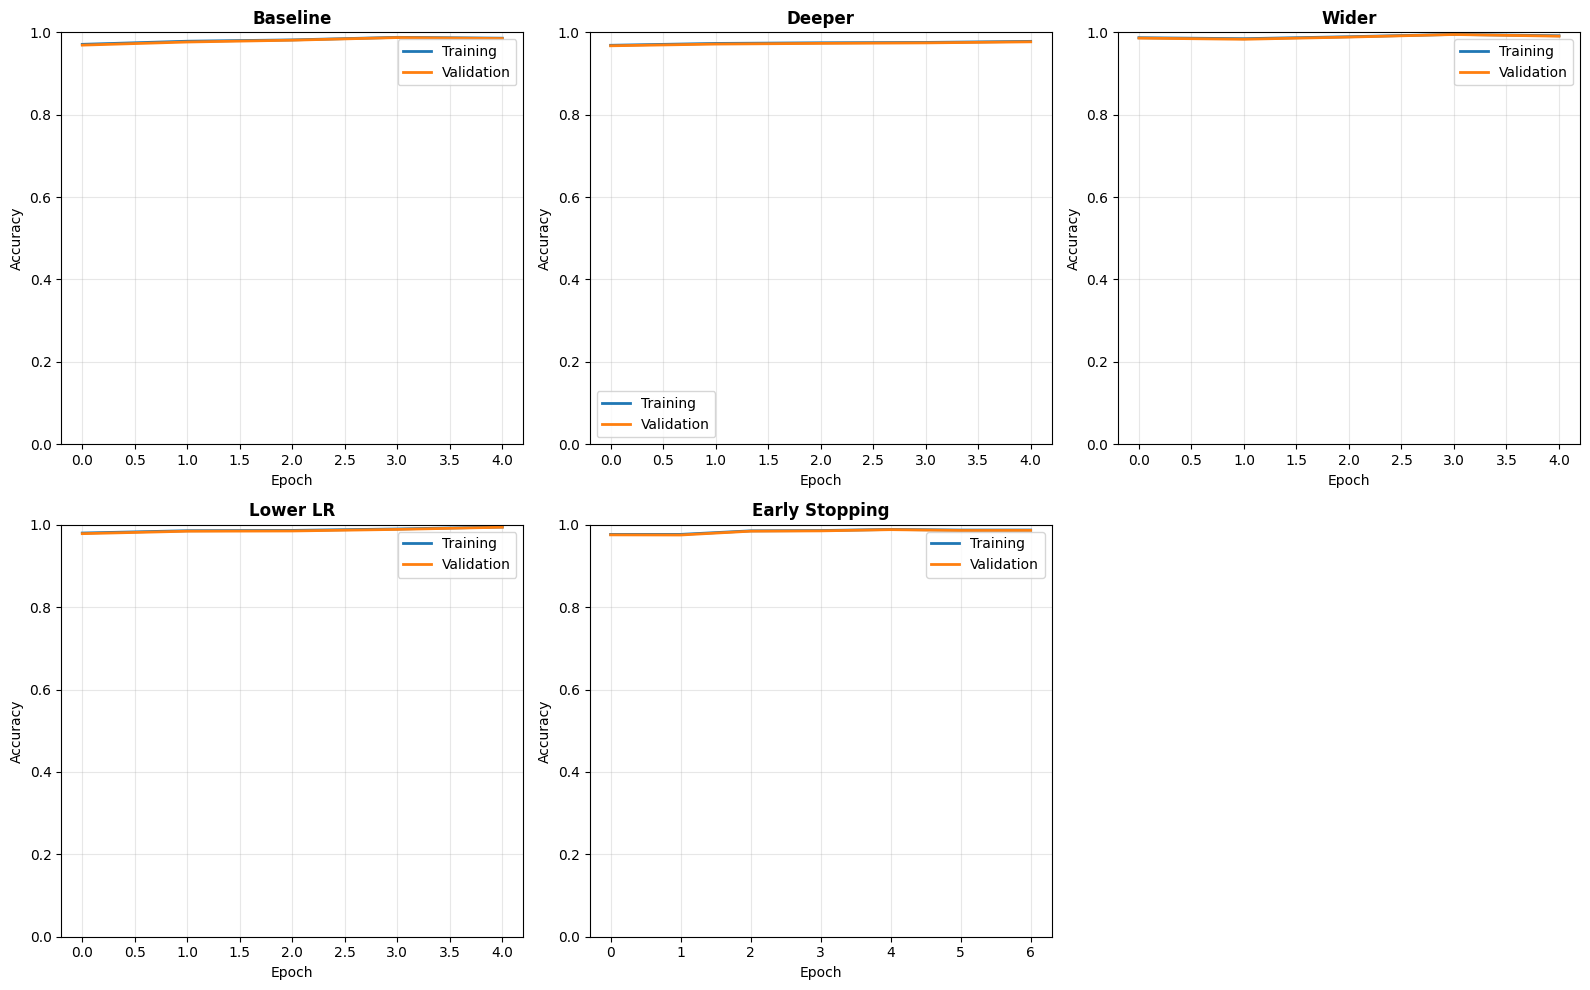

In [25]:
# SOLUTION: Visualize training history comparison
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

histories = [
    ('Baseline', history_baseline),
    ('Deeper', history_deep),
    ('Wider', history_wide),
    ('Lower LR', history_lr),
    ('Early Stopping', history_es)
]

for idx, (name, history) in enumerate(histories):
    ax = axes[idx]
    ax.plot(history['accuracy'], label='Training', linewidth=2)
    ax.plot(history['val_accuracy'], label='Validation', linewidth=2)
    ax.set_title(f'{name}', fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1])

# Remove extra subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

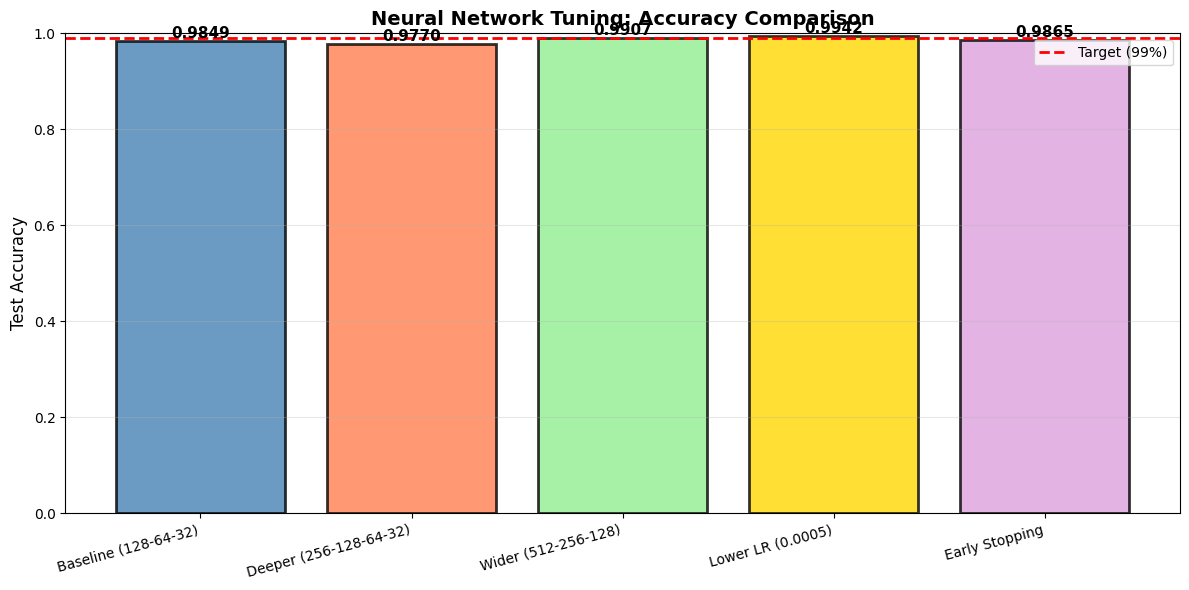

In [26]:
# SOLUTION: Bar chart comparison
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['steelblue', 'coral', 'lightgreen', 'gold', 'plum']
bars = ax.bar(range(len(results)), results['Test Accuracy'], color=colors, edgecolor='black', linewidth=2, alpha=0.8)

ax.set_ylabel('Test Accuracy', fontsize=12)
ax.set_title('Neural Network Tuning: Accuracy Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(results)))
ax.set_xticklabels(results['Experiment'], rotation=15, ha='right')
ax.set_ylim([0, 1])
ax.axhline(y=0.99, color='red', linestyle='--', linewidth=2, label='Target (99%)')
ax.grid(axis='y', alpha=0.3)
ax.legend()

for bar, acc in zip(bars, results['Test Accuracy']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## 5. Hyperparameter Analysis

In [27]:
# SOLUTION: Analyze impact of different hyperparameters
print("\n" + "="*60)
print("HYPERPARAMETER IMPACT ANALYSIS")
print("="*60)

print("\n1. Network Depth Impact:")
print(f"   Baseline (3 layers): {acc_baseline:.4f}")
print(f"   Deeper (4 layers): {acc_deep:.4f}")
print(f"   Impact: {(acc_deep - acc_baseline)*100:+.2f}%")

print("\n2. Network Width Impact:")
print(f"   Baseline (128-64-32): {acc_baseline:.4f}")
print(f"   Wider (512-256-128): {acc_wide:.4f}")
print(f"   Impact: {(acc_wide - acc_baseline)*100:+.2f}%")

print("\n3. Learning Rate Impact:")
print(f"   Standard (0.001): {acc_baseline:.4f}")
print(f"   Lower (0.0005): {acc_lr:.4f}")
print(f"   Impact: {(acc_lr - acc_baseline)*100:+.2f}%")

print("\n4. Early Stopping Impact:")
print(f"   Without: {acc_baseline:.4f}")
print(f"   With: {acc_es:.4f}")
print(f"   Impact: {(acc_es - acc_baseline)*100:+.2f}%")


HYPERPARAMETER IMPACT ANALYSIS

1. Network Depth Impact:
   Baseline (3 layers): 0.9849
   Deeper (4 layers): 0.9770
   Impact: -0.79%

2. Network Width Impact:
   Baseline (128-64-32): 0.9849
   Wider (512-256-128): 0.9907
   Impact: +0.57%

3. Learning Rate Impact:
   Standard (0.001): 0.9849
   Lower (0.0005): 0.9942
   Impact: +0.93%

4. Early Stopping Impact:
   Without: 0.9849
   With: 0.9865
   Impact: +0.16%
